In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler
import os

# --- 1. Load the dataset ---
file_name = '/content/dataset.csv'

if not os.path.exists(file_name):
    print(f"Error: The file '{file_name}' was not found in the current directory.")
    print("Please make sure the CSV file is in the same folder as the script.")
    exit()

# Read the CSV into a pandas DataFrame
df = pd.read_csv(file_name)
print(f"Successfully loaded '{file_name}'")


# --- 2. Clean and Rename Columns ---
# Clean up original column names
df.columns = df.columns.str.strip()

# Define a mapping from old column names to new ones
column_mapping = {
    'Genetics': 'Family_History_Diabetes',
    'Weight': 'Weight_kg',
    'Height': 'Height_cm',
    'Hypertension': 'High_Blood_Pressure',
    'Exercise': 'Exercise_Frequency',
    'Diabetes': 'Diabetes_Diagnosis'
}
df.rename(columns=column_mapping, inplace=True)
print("\nCleaned and renamed columns.")


# --- 3. Preprocess the data ---

# Function to extract numerical values from a string (for Age and Weight)
def clean_numeric(value):
    if isinstance(value, str):
        # Use regex to find the first sequence of digits (and optional decimal)
        numeric_part = re.search(r'[\d.]+', value)
        if numeric_part:
            return float(numeric_part.group(0))
    # If it's already a number or can't be parsed, return it as is
    if isinstance(value, (int, float)):
        return value
    return np.nan # Return NaN if no numeric part is found

# Function to convert various height formats to centimeters
def convert_height_to_cm(height_val):
    if isinstance(height_val, str):
        height_val = height_val.lower().strip().replace('"', '')
        # Format: 5'5, 5' 2, 5 feet 3.5 inches
        if "'" in height_val or "feet" in height_val:
            parts = re.findall(r'[\d.]+', height_val)
            feet = float(parts[0]) if len(parts) > 0 else 0
            inches = float(parts[1]) if len(parts) > 1 else 0
            return (feet * 12 + inches) * 2.54
        # Format: "4,9" (interpreted as 4 feet 9 inches)
        elif "," in height_val:
            parts = height_val.split(',')
            feet = float(parts[0]) if len(parts) > 0 else 0
            inches = float(parts[1]) if len(parts) > 1 else 0
            return (feet * 12 + inches) * 2.54
        # Format: numbers with "cm" or just numbers
        else:
            numeric_part = re.search(r'[\d.]+', height_val)
            if numeric_part:
                # Assume values > 30 are cm, otherwise they are likely feet that were written without a unit.
                num = float(numeric_part.group(0))
                if num > 30:
                    return num
                else: # Treat as feet (e.g., '5.3' becomes 5'3")
                    feet = int(num)
                    inches = (num - feet) * 10
                    return (feet * 12 + inches) * 2.54

    # If it's already a number, assume it's in cm
    elif isinstance(height_val, (int, float)):
        if height_val > 30:
             return height_val
        else: # Treat as feet
            feet = int(height_val)
            inches = (height_val - feet) * 10
            return (feet * 12 + inches) * 2.54
    return np.nan # Return NaN for unparseable formats

# Apply cleaning functions
print("Cleaning Age, Weight, and Height columns...")
df['Age'] = df['Age'].apply(clean_numeric)
df['Weight_kg'] = df['Weight_kg'].apply(clean_numeric)
df['Height_cm'] = df['Height_cm'].apply(convert_height_to_cm)


# --- 4. Encode categorical variables ---
print("Encoding categorical columns...")
# Gender: Female -> 0, Male -> 1
df['Gender'] = df['Gender'].str.strip().replace({'Female': 0, 'Male': 1})

# Binary columns: No -> 0, Yes -> 1
binary_cols = ['Family_History_Diabetes', 'High_Blood_Pressure', 'Diabetes_Diagnosis']
for col in binary_cols:
    df[col] = df[col].str.strip().replace({'No': 0, 'Yes': 1})

# Exercise Frequency: Ordinal encoding
exercise_map = {
    'Never': 0,
    '1-2 times': 1,
    '3-4 times': 2,
    '5 or more times': 3,
    '5 or more': 3 # Adding a variant found in the data
}
df['Exercise_Frequency'] = df['Exercise_Frequency'].str.strip().replace(exercise_map)

# Drop eating habits column as it is not part of the final request
df = df.drop(columns=['EatingHabits'])

# Convert all data to numeric, coercing errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Handle any potential missing values by filling with the median of the column
if df.isnull().sum().any():
    print("\nFound missing values after cleaning. Filling with column median.")
    df.fillna(df.median(), inplace=True)


# --- 5. Feature Engineering: Calculate BMI ---
print("Calculating BMI...")
# BMI = weight (kg) / (height (m))^2
# Ensure height is not zero to avoid division by zero error
height_m = df['Height_cm'] / 100
df['BMI'] = df['Weight_kg'] / (height_m.replace(0, np.nan) ** 2)
# Fill any NaN BMI values (from zero height) with the median BMI
if df['BMI'].isnull().any():
    df['BMI'].fillna(df['BMI'].median(), inplace=True)


# --- 6. Normalize Age and BMI ---
print("Normalizing Age and BMI columns...")
scaler = MinMaxScaler()
df[['Age', 'BMI']] = scaler.fit_transform(df[['Age', 'BMI']])


# --- 7. Remove original Height and Weight columns ---
print("Removing original Height and Weight columns...")
df = df.drop(columns=['Weight_kg', 'Height_cm'])


# --- 8. Display and Save the Preprocessed Data ---
print("\nPreprocessing complete. Displaying the first 20 rows of the final data:")
# Display all columns of the dataframe
pd.set_option('display.max_columns', None)
print(df.head(20).to_string())

# Save the preprocessed data to a new CSV file
output_filename = 'preprocessed_diabetes_data.csv'
df.to_csv(output_filename, index=False)
print(f"\nYour preprocessed file has been saved as '{output_filename}' in the current directory.")

Successfully loaded '/content/dataset.csv'

Cleaned and renamed columns.
Cleaning Age, Weight, and Height columns...
Encoding categorical columns...
Calculating BMI...
Normalizing Age and BMI columns...
Removing original Height and Weight columns...

Preprocessing complete. Displaying the first 20 rows of the final data:
         Age  Gender  Family_History_Diabetes  High_Blood_Pressure  Exercise_Frequency  Diabetes_Diagnosis       BMI
0   0.090909       0                        1                    0                   1                   0  0.426652
1   0.090909       1                        0                    0                   1                   0  0.335793
2   0.090909       1                        0                    0                   0                   0  0.423351
3   0.145455       1                        1                    0                   1                   1  0.497314
4   0.090909       1                        1                    0                   1      

/tmp/ipython-input-3723860657.py:100: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].str.strip().replace({'Female': 0, 'Male': 1})
/tmp/ipython-input-3723860657.py:105: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].str.strip().replace({'No': 0, 'Yes': 1})
/tmp/ipython-input-3723860657.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to 

In [ ]:

import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import RMSprop
from google.colab import files

file_name = '/content/preprocessed_diabetes_data.csv'

df = pd.read_csv(file_name)
print(f"Successfully loaded '{file_name}'")


# --- Step 2: Separate Features (X) and Target (y) ---
print("\nSeparating data into features (X) and target (y)...")
# The target is what we want to predict
y = df['Diabetes_Diagnosis']
# The features are all other columns used for prediction
X = df.drop('Diabetes_Diagnosis', axis=1)

# --- Step 3: Split Data into Training and Testing Sets ---
print("Splitting data into 80% training and 20% testing sets...")
# random_state ensures that the splits are the same every time we run the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set has {X_train.shape[0]} samples.")
print(f"Testing set has {X_test.shape[0]} samples.")

# --- Step 4: Build the Neural Network Architecture ---
print("\nBuilding the neural network model...")
model = Sequential([
    # Input layer: The shape must match the number of features
    InputLayer(input_shape=(X_train.shape[1],)),

    # First Hidden Layer: 12 neurons, 'relu' activation function
    # 'relu' is a great default for hidden layers
    Dense(12, activation='relu'),

    # Second Hidden Layer: 8 neurons
    Dense(8, activation='relu'),

    # Output Layer: 1 neuron, 'sigmoid' activation function
    # 'sigmoid' is used for binary (0 or 1) classification to output a probability
    Dense(1, activation='sigmoid')
])

# Display a summary of the model's architecture
print("\nModel Architecture Summary:")
model.summary()

# --- Step 5: Compile the Model ---
custom_optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


print("Model compiled successfully.")

# --- Step 6: Train the Model ---
print("\nStarting model training...")
# The model will learn from the training data over 100 epochs
# An epoch is one full pass through the entire training dataset
history = model.fit(
    X_train,
    y_train,
    epochs=120,
    batch_size=20,
    validation_data=(X_test, y_test), # Evaluate on test data at the end of each epoch
    verbose=1                        # Show progress for each epoch
)
print("Model training complete.")

# --- Step 7: Evaluate the Model ---
print("\nEvaluating the model's performance on the test set...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\nFinal Model Evaluation:")
print(f"  - Test Loss: {loss:.4f}")
print(f"  - Test Accuracy: {accuracy * 100:.2f}%")

Successfully loaded '/content/preprocessed_diabetes_data.csv'

Separating data into features (X) and target (y)...
Splitting data into 80% training and 20% testing sets...
Training set has 405 samples.
Testing set has 102 samples.

Building the neural network model...

Model Architecture Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197 (788.00 B)

 Trainable params: 197 (788.00 B)

 Non-trainable params: 0 (0.00 B)

Model compiled successfully.

Starting model training...
Epoch 1/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4224 - loss: 0.7162 - val_accuracy: 0.3824 - val_loss: 0.7335
Epoch 2/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4525 - loss: 0.7110 - val_accuracy: 0.4020 - val_loss: 0.7329
Epoch 3/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4638 - loss: 0.7103 - val_accuracy: 0.4118 - val_loss: 0.7321
Epoch 4/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4578 - loss: 0.7097 - val_accuracy: 0.4020 - val_loss: 0.7315
Epoch 5/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4978 - loss: 0.7064 - val_accuracy: 0.3824 - val_loss: 0.7308
Epoch 6/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4925 - loss: 0.7023 - val_accuracy: 0.3627 - val_loss: 0.7302
Epoch 7/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4741 - loss: 0.7094 - val_accuracy: 0.3725 - val_loss: 0.7296
Epoch 8/120
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

--- Classification Report (Standard 0.5 Threshold) ---
                 precision    recall  f1-score   support

No Diabetes (0)       0.79      0.36      0.49        61
   Diabetes (1)       0.47      0.85      0.61        41

       accuracy                           0.56       102
      macro avg       0.63      0.61      0.55       102
   weighted avg       0.66      0.56      0.54       102


--- ROC Curve and AUC ---
AUC Score: 0.6697

--- Optimal Threshold Evaluation ---
Optimal Threshold found at: 0.5542


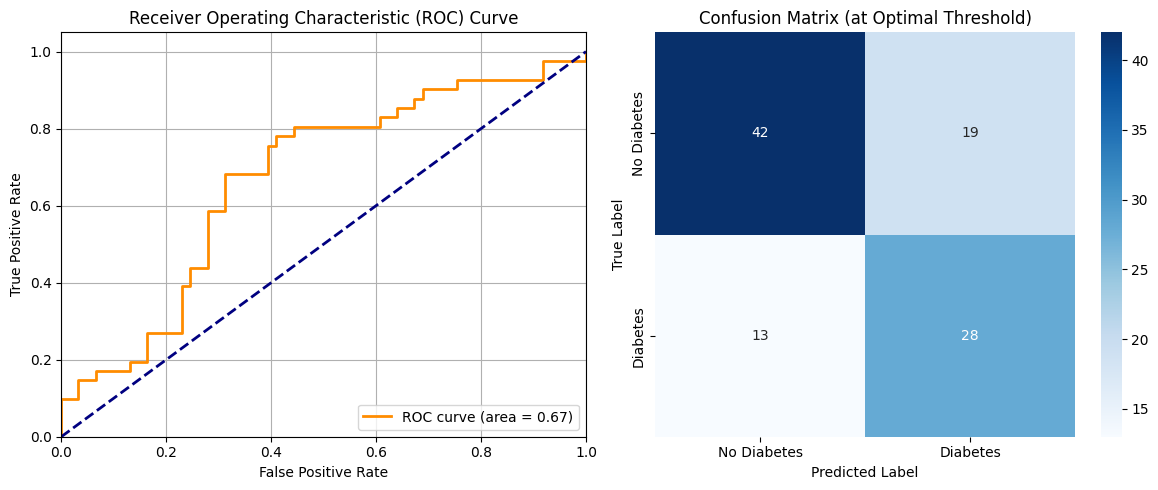


--- Learning Curves ---


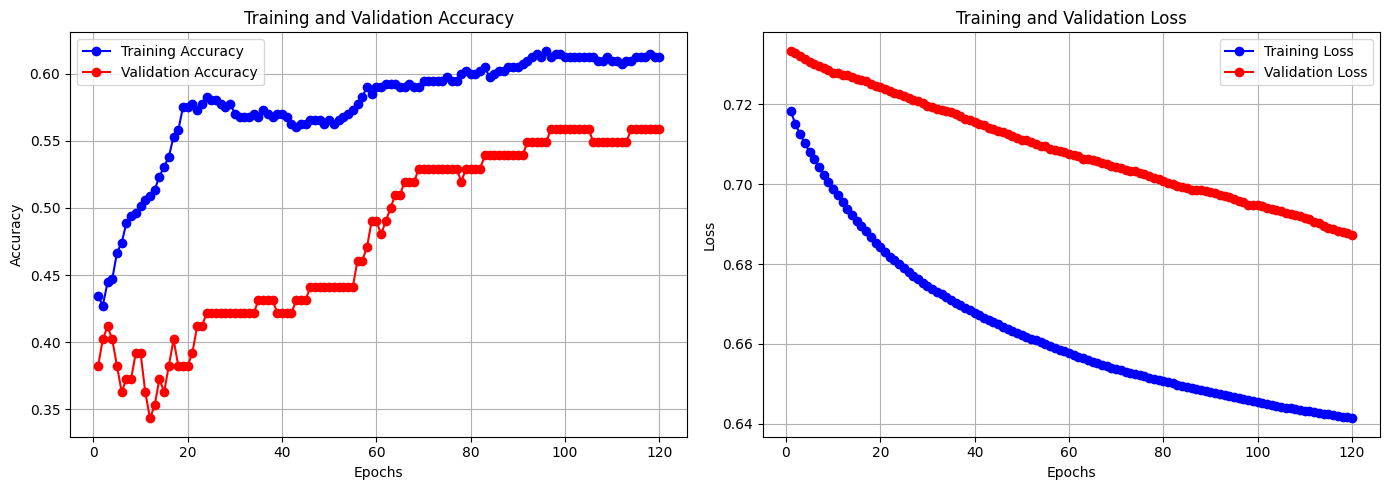


--- Evaluation Complete ---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    roc_curve,
    roc_auc_score,
    confusion_matrix
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# --- Step 1: Get Predictions from the Test Set ---
# Get probability predictions (for ROC/AUC, regression metrics)
y_pred_prob = model.predict(X_test).flatten()

# Get class predictions using the standard 0.5 threshold for the initial report
y_pred_class_standard = (y_pred_prob > 0.5).astype("int32")


# --- Step 2: Calculate Precision, Recall, F1-Score (using standard 0.5 threshold) ---
print("\n--- Classification Report (Standard 0.5 Threshold) ---")
# This report includes precision, recall, and f1-score for each class (0 and 1)
print(classification_report(y_test, y_pred_class_standard, target_names=['No Diabetes (0)', 'Diabetes (1)']))


# --- Step 3: Calculate and Plot ROC Curve and AUC ---
print("\n--- ROC Curve and AUC ---")
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")

# Plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.grid(True)
plt.legend(loc="lower right")


# --- Step 4: Calculate and Plot Optimal Confusion Matrix ---
print("\n--- Optimal Threshold Evaluation ---")

# Find the optimal threshold (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold found at: {optimal_threshold:.4f}")

# Create predictions based on the optimal threshold
y_pred_optimized = (y_pred_prob >= optimal_threshold).astype("int32")

# Calculate and plot the confusion matrix for the optimal threshold
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

plt.subplot(1, 2, 2)
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (at Optimal Threshold)')

plt.tight_layout()
plt.show()

# --- Step 5: Plot Learning Curves ---
print("\n--- Learning Curves ---")
# The 'history' object holds the training history
history_dict = history.history

# Get accuracy and loss values for training and validation sets
acc = history_dict.get('accuracy')
val_acc = history_dict.get('val_accuracy')
loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')

if acc and val_acc and loss and val_loss:
    # Create an array for the number of epochs
    epochs = range(1, len(acc) + 1)

    # Plot Training and Validation Accuracy & Loss
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Could not find 'accuracy', 'val_accuracy', 'loss', or 'val_loss' in history. Skipping learning curves.")


print("\n--- Evaluation Complete ---")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler here as it's used in interactive_prediction

def interactive_prediction():
    """
    An interactive function to predict diabetes risk based on user input.
    This version matches the exact features used in model training.
    """
    print("\n--- Interactive Diabetes Risk Prediction ---")
    print("Please enter the following details:")

    try:
        # Get feature names from the original DataFrame before splitting
        # This assumes the original df dataframe is available in the environment
        if 'df' not in globals() and 'df' not in locals():
             print("Error: The original 'df' DataFrame is not available. Please run the data preprocessing cell first.")
             return
        # Exclude the target variable 'Diabetes_Diagnosis' from feature names
        feature_names = [col for col in df.columns if col != 'Diabetes_Diagnosis']
        expected_features = len(feature_names) # Get number of features from the list

        print(f"Model expects {expected_features} features: {feature_names}")
        print()

        # --- Collect User Input for ALL features in the training data ---
        user_input = {}

        # Create input based on the exact columns from training data
        for feature in feature_names:
            if feature.lower() == 'age':
                user_input[feature] = float(input(f"Enter {feature} (e.g., 35): "))
            elif feature.lower() == 'gender':
                gender_str = input(f"Enter {feature} ('female' or 'male'): ").lower()
                user_input[feature] = 0 if gender_str == 'female' else 1
            elif 'family' in feature.lower() and 'diabetes' in feature.lower():
                history_str = input(f"{feature} - Family history of diabetes? ('yes' or 'no'): ").lower()
                user_input[feature] = 1 if history_str == 'yes' else 0
            elif 'blood' in feature.lower() and 'pressure' in feature.lower():
                bp_str = input(f"{feature} - Have you ever had high blood pressure? ('yes' or 'no'): ").lower()
                user_input[feature] = 1 if bp_str == 'yes' else 0
            elif 'exercise' in feature.lower():
                print("How often do you exercise per week?")
                exercise_str = input("Enter 'never', '1-2 times', '3-4 times', or '5 or more times'): ").lower()
                exercise_map = {'never': 0, '1-2 times': 1, '3-4 times': 2, '5 or more times': 3}
                user_input[feature] = exercise_map.get(exercise_str, 0)
            elif feature.lower() == 'bmi':
                weight_kg = float(input("Enter Weight in Kilograms (e.g., 70): "))
                height_cm = float(input("Enter Height in Centimeters (e.g., 175): "))
                height_m = height_cm / 100
                if height_m == 0:
                    print("Error: Height cannot be zero.")
                    return
                user_input[feature] = weight_kg / (height_m ** 2)


        # --- Create DataFrame with exact same structure as training data ---
        # Ensure the order of columns matches the training data features
        input_data = pd.DataFrame([user_input])[feature_names]


        # --- Apply same preprocessing as training data ---
        # If a scaler was used during training, apply it here
        # This assumes you have a 'scaler' object defined in your training cell
        if 'scaler' in globals() or 'scaler' in locals():
            try:
                # Apply scaler to the same columns that were scaled during training
                # These columns are explicitly scaled in the preprocessing cell
                columns_to_scale = ['Age', 'BMI'] # Assuming BMI is calculated and then scaled
                # Filter for columns that actually exist in the input data and were scaled
                existing_columns_to_scale = [col for col in columns_to_scale if col in input_data.columns]

                if existing_columns_to_scale:
                    # Reshape input_data for scaling if it's not already a DataFrame/series
                    input_data[existing_columns_to_scale] = scaler.transform(input_data[existing_columns_to_scale])
                    print(f"Applied scaling to: {existing_columns_to_scale}")
                else:
                    print("No scalable columns found in input data to apply scaler.")

            except Exception as scale_error:
                print(f"Warning: Could not apply scaler. Ensure 'scaler' is defined from training: {scale_error}")
                print("Proceeding with potentially unscaled data...")
        else:
            print("Warning: 'scaler' object not found. Proceeding without applying scaling.")


        # Debug information
        print(f"\nInput data shape: {input_data.shape}")
        print(f"Input data:\n{input_data}")

        # --- Make Prediction ---
        # The model expects a NumPy array as input
        prediction_prob = model.predict(input_data.values)[0][0]
        prediction_class = "High Risk" if prediction_prob > 0.5 else "Low Risk"

        # --- Display the Result ---
        print("\n" + "="*50)
        print("--- PREDICTION RESULT ---")
        if 'BMI' in user_input:
            print(f"Calculated BMI: {user_input['BMI']:.2f}")
        print(f"Risk Assessment: {prediction_class}")
        print(f"Probability: {prediction_prob:.2%}")
        print("="*50 + "\n")

    except ValueError as ve:
        print(f"\nError: Invalid input - {ve}")
        print("Please make sure you enter valid numbers where required.\n")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")
        print("Please check that the model, training data, and original DataFrame 'df' are properly loaded.\n")


# --- Main execution ---
if __name__ == '__main__':
    # Check if required objects exist
    if 'model' not in locals() and 'model' not in globals():
        print("Error: The 'model' object is not defined. Please run the training cell first.")
    # We now check for 'df' to get feature names instead of X_train.columns
    elif 'df' not in locals() and 'df' not in globals():
        print("Error: The 'df' DataFrame is not defined. Please run the data preprocessing cell first.")
        print("We need this to know what features the model expects.")
    else:
        # Get feature names from the original DataFrame before splitting
        feature_names = [col for col in df.columns if col != 'Diabetes_Diagnosis']
        print("=== Model Information ===")
        print(f"Model expects {len(feature_names)} features: {feature_names}")
        print("="*50 + "\n")

        while True:
            interactive_prediction()
            another = input("Do you want to make another prediction? (yes/no): ").lower()
            if another != 'yes':
                print("Exiting interactive session.")
                break

=== Model Information ===
Model expects 6 features: ['Age', 'Gender', 'Family_History_Diabetes', 'High_Blood_Pressure', 'Exercise_Frequency', 'BMI']


--- Interactive Diabetes Risk Prediction ---
Please enter the following details:
Model expects 6 features: ['Age', 'Gender', 'Family_History_Diabetes', 'High_Blood_Pressure', 'Exercise_Frequency', 'BMI']

Enter Age (e.g., 35): 26
Enter Gender ('female' or 'male'): male
Family_History_Diabetes - Family history of diabetes? ('yes' or 'no'): yes
High_Blood_Pressure - Have you ever had high blood pressure? ('yes' or 'no'): no
How often do you exercise per week?
Enter 'never', '1-2 times', '3-4 times', or '5 or more times'): 5 or more times
